Jumlah gambar ditemukan: 18
 - img\0003_0001.JPG
 - img\0003_0002.JPG
 - img\0003_0003.JPG
 - img\0011_0005.JPG
 - img\0014_0002.JPG
 - img\0014_0003.JPG
 - img\0014_0005.JPG
 - img\0022_0003.JPG
 - img\0022_0004.JPG
 - img\0003_0001.JPG


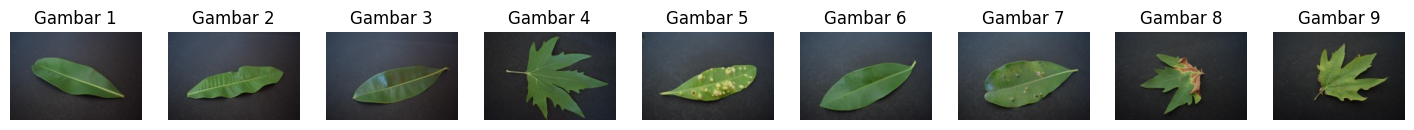

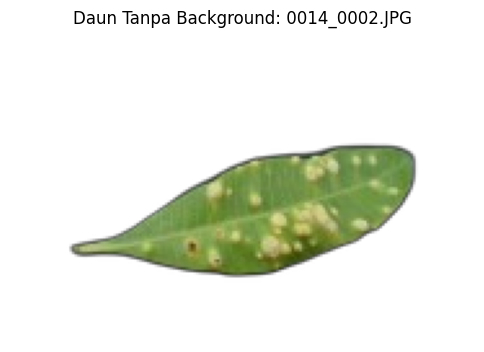

Tipe data gambar: <class 'PIL.Image.Image'>
Mode warna: RGBA
Ukuran gambar: (180, 120)


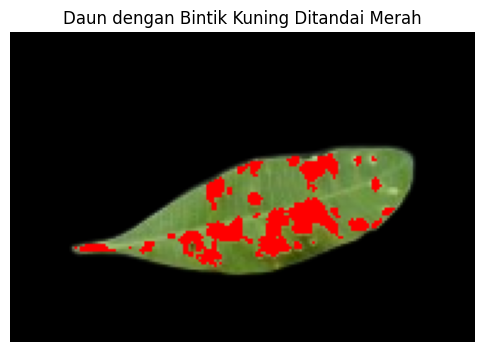

Jumlah pixel bintik : 937
Total pixel daun    : 3684
Persentase area bintik: 25.43%
 Daun BERPENYAKIT (banyak bintik kuning).


In [ ]:
import os
import glob
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from rembg import remove
from PIL import Image


#  Persiapan Dataset

dataset_path = "img/"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Folder tidak ditemukan: {dataset_path}")

# Ambil semua gambar dengan ekstensi umum
image_paths = []
for ext in ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.PNG"):
    image_paths.extend(glob.glob(os.path.join(dataset_path, "**", ext), recursive=True))

print("Jumlah gambar ditemukan:", len(image_paths))
for path in image_paths[:10]:
    print(" -", path)


#  Tampilkan Contoh Gambar

plt.figure(figsize=(18, 9))
for i, path in enumerate(image_paths[:9]):  # tampilkan 9 gambar pertama
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 9, i + 1)
    plt.imshow(img)
    plt.title(f"Gambar {i + 1}")
    plt.axis('off')
plt.show()


#  Hapus Latar Belakang (Background)

image_path = image_paths[4]  # pakai 1 gambar contoh (bisa diubah sesuai kebutuhan)

with open(image_path, "rb") as f:
    input_image = f.read()

# Hapus background menggunakan rembg
output_image = remove(input_image)
result = Image.open(io.BytesIO(output_image)).convert("RGBA")

plt.figure(figsize=(6, 6))
plt.imshow(result)
plt.title(f"Daun Tanpa Background: {os.path.basename(image_path)}")
plt.axis("off")
plt.show()

print("Tipe data gambar:", type(result))
print("Mode warna:", result.mode)
print("Ukuran gambar:", result.size)


#  Segmentasi Daun & Deteksi Bintik Kuning


# Konversi hasil remove background ke numpy array (tanpa alpha)
img_rgb = cv2.cvtColor(np.array(result), cv2.COLOR_RGBA2RGB)
h, w, c = img_rgb.shape
img_flat = img_rgb.reshape((-1, 3))

# --- Segmentasi daun dengan K-Means ---
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(img_flat)
labels_2d = labels.reshape(h, w)
centers = kmeans.cluster_centers_.astype(np.uint8)

# Tentukan cluster daun (yang lebih hijau)
green_scores = centers[:, 1] - (centers[:, 0] + centers[:, 2]) / 2
leaf_cluster_idx = np.argmax(green_scores)
mask_leaf = (labels_2d == leaf_cluster_idx).astype(np.uint8) * 255

# --- Konversi ke HSV untuk deteksi warna kuning ---
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

# Range warna kuning untuk deteksi bintik
lower_yellow = np.array([15, 50, 150])
upper_yellow = np.array([40, 255, 255])
mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

# Hanya area daun
mask_spots = cv2.bitwise_and(mask_yellow, mask_leaf)

# Tandai bintik dengan warna merah
img_bgr_marked = img_bgr.copy()
img_bgr_marked[mask_spots > 0] = [0, 0, 255]

# Tampilkan hasil
img_result = Image.fromarray(cv2.cvtColor(img_bgr_marked, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(6, 6))
plt.imshow(img_result)
plt.axis("off")
plt.title("Daun dengan Bintik Kuning Ditandai Merah")
plt.show()


#  Analisis Persentase Bintik (Kerusakan)

num_bintik = np.sum(mask_spots > 0)
total_daun = np.sum(mask_leaf > 0)
persentase_bintik = (num_bintik / total_daun) * 100 if total_daun > 0 else 0

print(f"Jumlah pixel bintik : {num_bintik}")
print(f"Total pixel daun    : {total_daun}")
print(f"Persentase area bintik: {persentase_bintik:.2f}%")


#  Interpretasi

if persentase_bintik < 5:
    print(" Daun tergolong SEHAT.")
elif persentase_bintik < 20:
    print(" Daun mulai TERKENA penyakit ringan.")
else:
    print(" Daun BERPENYAKIT (banyak bintik kuning).")
